In [1]:
import pickle
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

file_name = "220426_1444_English_Czech"

In [2]:
with open("./morphological_tagging/data/uni_morph_tags.json", "rb") as f:
        uni_morph_tags = json.load(f)

morph_tag_vocab = {
    feat: long_feat for feat, [long_feat, _] in uni_morph_tags.items()
}

morph_tag_cat_vocab = {
    feat: cat for feat, [_, cat] in uni_morph_tags.items()
}

morph_cat_tag_vocab = defaultdict(set)
for k, v in morph_tag_cat_vocab.items():
    morph_cat_tag_vocab[v].add(k)
morph_cat_tag_vocab = dict(morph_cat_tag_vocab)

In [3]:
with open(f"./nmt_adapt/eval/{file_name}.pickle", "rb") as f:
    eval_data = pickle.load(f)

# Histograms

In [4]:
include_or_exclude = "include"
tags = {"prs"}

# Function body ================================================================
def get_tag_data(eval_data, tags, include_or_exclude: str = "include", lemma_lim: float = 0.0):

    if len(tags) == 1:
        mode = list(tags)[0]

    elif len(tags) >= 1 and include_or_exclude == "include":
        mode = "Inclusive"

    else:
        mode = "Exclusive"

    # Get all morph_tag_sets where the tags are included, include exactly once or excluded
    if include_or_exclude == "include":
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) >= 1}

    elif include_or_exclude == "once":
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) == 1}

    else:
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) < 1}

    # Filter out instances not marked for a POS (probably errors)
    tag_sets_matching = {
        tag_set for tag_set in list(tag_sets_matching)
        if len(set.intersection(morph_cat_tag_vocab["Part of Speech"], {t.lower() for t in list(tag_set)})) >= 1
        }

    if len(tag_sets_matching) == 0:
        return None

    lemma_agg_results = []
    for tag_set in list(tag_sets_matching):
        for lemma, lemma_results in eval_data[tag_set].items():
            for instance in lemma_results:
                if instance["lemma_match"] >= lemma_lim:

                    record = {"mode": mode, "tag_set": tag_set, "lemma": lemma}
                    record |= {k: v for k, v in instance.items() if k != "confusion"}

                    lemma_agg_results += [record]

    return lemma_agg_results

In [14]:
cat = "Person"

# Function body ================================================================
cat_data = []

cat_data.extend(
    get_tag_data(eval_data, morph_cat_tag_vocab[cat], include_or_exclude="include", lemma_lim=1/24)
)

cat_data.extend(
    get_tag_data(eval_data, morph_cat_tag_vocab[cat], include_or_exclude="exclude", lemma_lim=1/24)
)

for tag in sorted(list(morph_cat_tag_vocab[cat])):
    tag_data = get_tag_data(eval_data, {tag}, include_or_exclude="once", lemma_lim=1/24)
    if tag_data is not None:
        cat_data.extend(
            tag_data
        )

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_records(cat_data)
metric = "morph_tag_iou"

c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


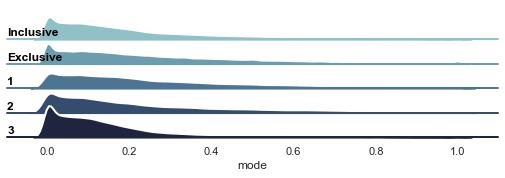

In [13]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(set(df["mode"])), rot=-.25, light=.7)
g = sns.FacetGrid(df, row="mode", hue="mode", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, metric,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, metric, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "mode")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


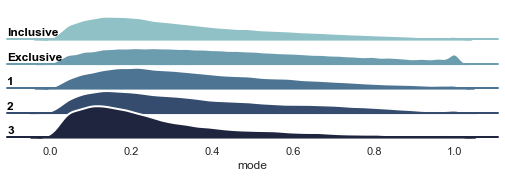

In [16]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(set(df["mode"])), rot=-.25, light=.7)
g = sns.FacetGrid(df, row="mode", hue="mode", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, metric,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, metric, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "mode")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


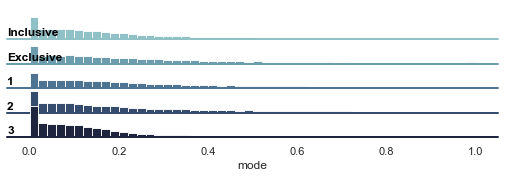

In [99]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(set(df["mode"])), rot=-.25, light=.7)
g = sns.FacetGrid(df, row="mode", hue="mode", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.histplot, metric,
      clip_on=False,
      fill=True, alpha=1,
      stat="percent",
      bins=50,
      )

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "mode")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [76]:
df[df["mode"] == "Inclusive"]["morph_tag_iou"].mean()

0.2288759262279001

In [93]:
df_lemma_macro = df.groupby(["mode", "tag_set", "lemma"]).mean().reset_index()
df_lemma_macro["mode"] = pd.Categorical(df_lemma_macro["mode"], categories=["Inclusive", "Exclusive", "1", "2", "3"], ordered=True)
df_lemma_macro = df_lemma_macro.sort_values("mode")


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


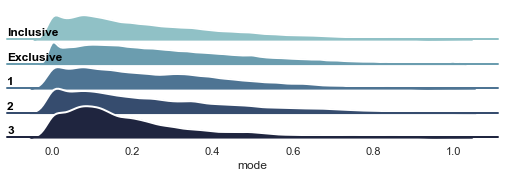

In [94]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(set(df_lemma_macro["mode"])), rot=-.25, light=.7)
g = sns.FacetGrid(df_lemma_macro, row="mode", hue="mode", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, metric,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, metric, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "mode")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Inclusive/Exclusive Plots

In [18]:
import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.cm.get_cmap('tab10')

def get_stats_morph_tags(eval_data, tags, metric, include_or_exclude: str = "include", lemma_lim: float = 0.0):

    # Get all morph_tag_sets where the tags are included, include exactly once or excluded
    if include_or_exclude == "include":
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) >= 1}

    elif include_or_exclude == "once":
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) == 1}

    else:
        tag_sets_matching = {tag_set for tag_set in eval_data.keys() if len(set.intersection(tags, {t.lower() for t in list(tag_set)})) < 1}

    # Filter out instances not marked for a POS (probably errors)
    tag_sets_matching = {
        tag_set for tag_set in list(tag_sets_matching)
        if len(set.intersection(morph_cat_tag_vocab["Part of Speech"], {t.lower() for t in list(tag_set)})) >= 1
        }

    if len(tag_sets_matching) == 0:
        return None

    # Iterate over these morph_tag_sets and generate summary statistics over all possible lemmas
    tag_sets_all_points = []
    tag_sets_points = []
    for tag_set in list(tag_sets_matching):
        tag_set_lemma_agg = []
        for _, lemma_results in eval_data[tag_set].items():
            lemma_results_agg = []

            for instance in lemma_results:
                if instance["lemma_match"] >= lemma_lim:
                    lemma_results_agg.append(instance[metric])
                    tag_sets_all_points.append(instance[metric])

            lemma_mean = np.mean(lemma_results_agg)
            lemma_N = len(lemma_results_agg)
            lemma_sum = np.sum(lemma_results_agg)
            lemma_sumsq = np.sum(np.power(lemma_results_agg, 2))

            tag_set_lemma_agg.append((lemma_mean, lemma_N, lemma_sum, lemma_sumsq))

        tag_sets_points.extend(tag_set_lemma_agg)

    # Transpose the lists
    tag_lemma_mean, tag_lemma_N, tag_lemma_sum, tag_lemma_sumsq = list(map(np.array, zip(*tag_sets_points)))

    # Compute aggregated summary statistics
    tN = np.sum(tag_lemma_N)
    tS = np.sum(tag_lemma_sum)
    tS2 = np.sum(tag_lemma_sumsq)

    tag_mean_micro = tS / tN
    tag_std_micro = np.sqrt(((tS2 - np.power(tS, 2)/tN) / (tN - 1)))
    tag_N_micro = tN
    tag_quantiles_micro = np.quantile(tag_sets_all_points, [0, 0.125, 0.25, 0.341, 0.50, 0.68, 0.75, 0.875, 1])

    tag_mean_macro = np.mean(tag_lemma_mean)
    tag_std_macro = np.std(tag_lemma_mean)
    tag_N_macro = tag_lemma_mean.shape[0]
    tag_quantiles_macro = np.quantile(tag_lemma_mean, [0, 0.125, 0.25, 0.341, 0.50, 0.68, 0.75, 0.875, 1])

    return (tag_mean_micro, tag_std_micro, tag_N_micro, tag_quantiles_micro), (tag_mean_macro, tag_std_macro, tag_N_macro, tag_quantiles_macro)

def get_stats_morph_cat(eval_data, morph_cat_tag_vocab, cat: str, metric: str, lemma_lim: float = 0.0):

    micro = dict()
    macro = dict()

    inclusive = get_stats_morph_tags(
        eval_data,
        morph_cat_tag_vocab[cat],
        metric,
        include_or_exclude="include",
        lemma_lim=lemma_lim,
        )

    if inclusive is None:
        return None, None

    micro["inclusive"] = inclusive[0]
    macro["inclusive"] = inclusive[1]

    exclusive = get_stats_morph_tags(
        eval_data,
        morph_cat_tag_vocab[cat],
        metric,
        include_or_exclude="exclude",
        lemma_lim=lemma_lim,
        )

    if exclusive is not None:
        micro["exclusive"] = exclusive[0]
        macro["exclusive"] = exclusive[1]

    else:
        micro["exclusive"] = (0, 0, 0, [0 for _ in range(9)])
        macro["exclusive"] = (0, 0, 0, [0 for _ in range(9)])

    for tag in list(morph_cat_tag_vocab[cat]):
        tag_data = get_stats_morph_tags(
                eval_data,
                {tag},
                metric,
                include_or_exclude="once",
                lemma_lim=lemma_lim,
                )

        if tag_data is not None:
            micro[tag] = tag_data[0]
            macro[tag] = tag_data[1]

    return micro, macro

def cat_agg_plot(
    eval_data,
    morph_cat_tag_vocab,
    category: str,
    micro_or_macro = "micro",
    metric="morph_tag_iou",
    mean_size = 150,
    colours = {
        "inclusive": cmap(0),
        "exclusive": cmap(1),
        "tag": cmap(2)
    },
    xlim = (0, 1),
    lemma_lim: float = 0.0,
):
    # ==============================================================================
    # Get aggregated data
    # ==============================================================================
    micro, macro = get_stats_morph_cat(
        eval_data=eval_data,
        morph_cat_tag_vocab=morph_cat_tag_vocab,
        cat=category,
        metric=metric,
        lemma_lim=lemma_lim,
        )

    if micro is None:
        return None, None

    agg_stats = micro if micro_or_macro == "micro" else macro

    quantiles = [
        ("inclusive", np.concatenate([[agg_stats["inclusive"][0]], agg_stats["inclusive"][-1]]), agg_stats["inclusive"][2]),
        ("exclusive", np.concatenate([[agg_stats["exclusive"][0]], agg_stats["exclusive"][-1]]), agg_stats["exclusive"][2]),
    ]

    for tag in sorted(list(agg_stats.keys())):
        if tag in ['exclusive', 'inclusive']:
            continue

        quantiles.append(
            (tag, np.concatenate([[agg_stats[tag][0]], agg_stats[tag][-1]]), agg_stats[tag][2])
        )

    positions = range(len(quantiles))[::-1]

    # ==============================================================================
    # Boxplots
    # ==============================================================================
    bxp_stats_1 = [
        {
            "mean": v[0],
            "med": v[6],
            "q1": v[5],
            "q3": v[7],
            "whislo": v[5],
            "whishi": v[7]}
        for _, v, _ in quantiles
        ]

    bxp_stats_2 = [
        {
            "med": v[6],
            "q1": v[4],
            "q3": v[8],
            "whislo": v[3],
            "whishi": v[9]}
        for _, v, _ in quantiles
        ]

    min_outer_box = min(v[4] for _, v, _ in quantiles)
    max_outer_box = max(v[8] for _, v, _ in quantiles)
    max_iqr = max(v[8] - v[4] for _, v, _ in quantiles)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    boxprops = {"linestyle":'-', "linewidth": 1, "facecolor": "white", "edgecolor": "black"}
    medianprops = {"linestyle":'-', "linewidth": 1, "color": "black"}
    meanpointprops = {"marker": 'D', "markeredgecolor": 'black', "markerfacecolor": 'black'}

    ax.bxp(
        bxp_stats_1,
        positions=positions,
        showmeans=False,
        showfliers=False,
        shownotches=False,
        showcaps=False,
        vert=False,
        widths=0.2,
        zorder=2,
        patch_artist=True,
        boxprops=boxprops,
        medianprops=medianprops,
        meanprops=meanpointprops
    )

    ax.bxp(
        bxp_stats_2,
        positions=positions,
        showfliers=False,
        shownotches=False,
        showcaps=False,
        vert=False,
        widths=0.1,
        zorder=1,
        patch_artist=True,
        boxprops=boxprops,
        medianprops=medianprops,
    )
    ax.set_yticklabels([k for k, _, _ in quantiles] * 2)

    if xlim is not None:
        ax.set_xlim(-0.05 + xlim[0], 0.05 + xlim[1])
    else:
        ax.set_xlim(min_outer_box - 0.5 * max_iqr, max_outer_box + max_iqr * 0.5)

    ax.set_ylim(-1, len(quantiles))
    ax.vlines(
        x=quantiles[0][1][0],
        ymin=-1,
        ymax=len(quantiles),
        ls="--",
        color="black",
        zorder=-1,
    )

    # ==============================================================================
    # Mean Points
    # ==============================================================================

    means = np.array([q[0] for _, q, _ in quantiles])
    Ns = np.array([N for _, _, N in quantiles])

    sizes = mean_size * np.sqrt((Ns / Ns.sum()))

    ax.scatter(
        x=means,
        y=positions,
        s=sizes,
        c=[colours["inclusive"], colours["exclusive"]] + [colours["tag"]] * (means.shape[0] - 2),
        zorder=3,
        marker="D"
    )

    ax.set_title(f"{category} - {metric}")

    return fig, agg_stats


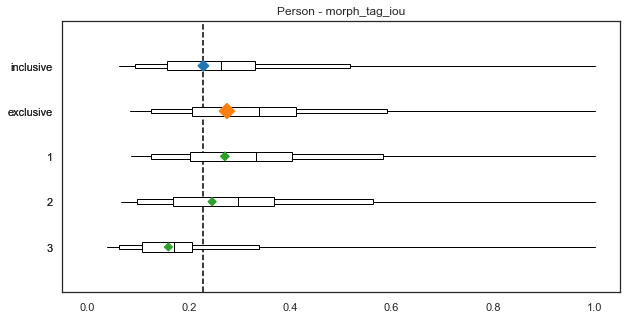

In [20]:
fig, agg_stats = cat_agg_plot(
    eval_data,
    morph_cat_tag_vocab,
    category="Person",
    metric="morph_tag_iou",
    xlim=(0,1) if "lev" not in metric and metric != "entropy" else None,
    lemma_lim=0/24,
)


In [32]:
list(list(eval_data.values())[0].values())[0][0].keys()

dict_keys(['char_match', 'lev_dist', 'norm_lev_dist', 'chrf_1', 'chrf_2', 'chrf_3', 'chrf_4', 'chrf_5', 'spe_match', 'spe_lev_dist', 'spe_norm_lev_dist', 'lemma_match', 'lemma_norm_lev_dist', 'morph_tag_match', 'morph_tag_iou', 'morph_cat_iou', 'confusion', 'morph_tag_iou_at_match', 'entropy'])

c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


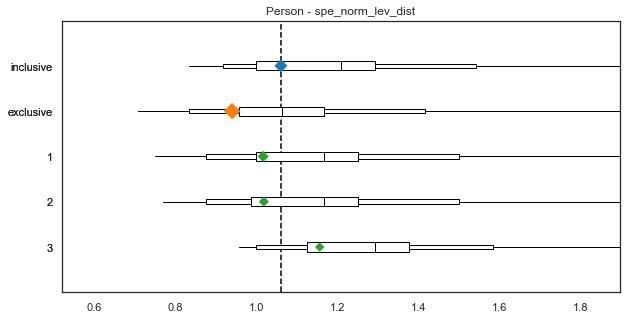

In [43]:
metric = "spe_norm_lev_dist"

fig, agg_stats = cat_agg_plot(
    eval_data,
    morph_cat_tag_vocab,
    category="Person",
    metric=metric,
    xlim=(0,1) if "lev" not in metric and metric != "entropy" else None,
    lemma_lim=1/24,
)


In [36]:
import math

math.exp(2.3), math.exp(2.6)

(9.974182454814718, 13.463738035001692)

c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Tense/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Tense/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Tense/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Tense/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Tense/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Comparison/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Comparison/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Comparison/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Comparison/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Comparison/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Case/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Case/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Case/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Case/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Case/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Voice/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Voice/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Voice/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Voice/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Voice/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Part of Speech/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Part of Speech/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Part of Speech/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Part of Speech/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Part of Speech/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Mood/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Mood/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Mood/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Mood/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Mood/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Animacy/morph_tag_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Animacy/morph_cat_iou.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Animacy/norm_lev_dist.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Animacy/chrf_3.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Animacy/entropy.png


c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ivoon\Anaconda3\envs\msc_thesis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

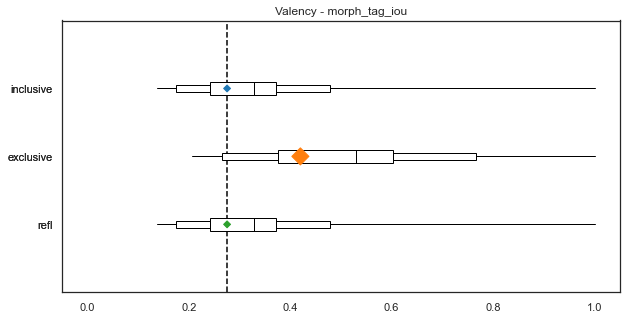

In [45]:
import os
from itertools import combinations
from collections import defaultdict

base_fp = "./nmt_adapt/eval/figures/220426_1444_English_Czech"

metric_inter_mean_dist = defaultdict(list)
for cat in list(morph_cat_tag_vocab.keys()):


    for metric in ["morph_tag_iou", "morph_cat_iou", "norm_lev_dist", "chrf_3", "entropy"]:

        fig, agg_stats = cat_agg_plot(
            eval_data,
            morph_cat_tag_vocab,
            category=cat,
            metric=metric,
            xlim=(0,1) if "lev" not in metric and metric != "entropy" else None,
            lemma_lim=1/64,
        )

        if fig is not None:
            os.makedirs(base_fp + f"/{cat}", exist_ok=True)

            means = [v[0] for k, v in agg_stats.items() if k not in ["inclusive", "exclusive"]]
            inter_mean_dist = np.max(np.abs([m1 - m2 for m1, m2 in combinations(means, r=2)])) / np.std(means)

            metric_inter_mean_dist[metric].append(inter_mean_dist)

            fig.savefig(
                f"{base_fp}/{cat}/{metric}.png"
            )
            print(f"{base_fp}/{cat}/{metric}.png")

            plt.close(fig)


In [46]:
means

[0.2755433024588082]

In [ ]:
{k : np.nanmean(v) for k, v in metric_inter_mean_dist.items()}

{'morph_tag_iou': 0.04359252802171976,
 'morph_cat_iou': 0.04087064144360507,
 'norm_lev_dist': 0.10604477719376758}

# 'Treatment Effect' Estimate

In [47]:
from collections import defaultdict

lemmas_per_mtag_set = {k: set(v.keys()) for k, v in list(eval_data.items())}

tag_lemmas = defaultdict(list)
lemmas_inverse_index = defaultdict(list)
for k, v in lemmas_per_mtag_set.items():
    for vv in list(v):
        lemmas_inverse_index[vv].append(k)

        for kk in list(k):
            tag_lemmas[kk.lower()].append(vv)

tag_lemmas = dict(tag_lemmas)
lemmas_inverse_index = dict(lemmas_inverse_index)


In [ ]:
    lemma_results = []
    for l in tag_lemmas[tag]:
        inclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() in set(tag_set) and "_" not in set(tag_set)]
        exclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() not in set(tag_set) and "_" not in set(tag_set)]

        if len(inclusive_examples) == 0 or len(exclusive_examples) == 0:
            continue

        inclusive_stats = defaultdict(list)
        for tag_set in inclusive_examples:
            for instance in eval_data[tag_set][l]:
                for metric, metric_val in instance.items():
                    if metric != "confusion":
                        inclusive_stats[metric].append(metric_val)
        inclusive_stats = dict(inclusive_stats)

        N_inclusive = len(list(inclusive_stats.values())[0])
        inclusive_stats = {k: np.mean(v) for k, v in inclusive_stats.items()}

        exclusive_stats = defaultdict(list)
        for tag_set in exclusive_examples:
            for instance in eval_data[tag_set][l]:
                for metric, metric_val in instance.items():
                    if metric != "confusion":
                        exclusive_stats[metric].append(metric_val)
        exclusive_stats = dict(exclusive_stats)

        N_exclusive = len(list(exclusive_stats.values())[0])
        exclusive_stats = {k: np.mean(v) for k, v in exclusive_stats.items()}

        expected_difference = {k: v - exclusive_stats[k] for k, v in inclusive_stats.items()}

        lemma_results.append((N_inclusive + N_exclusive, expected_difference))

    agg_counts = defaultdict(list)
    agg_vals = defaultdict(list)
    for count, stats in lemma_results:
        if micro_or_macro == "macro":
            count = 1
        for metric, metric_val in stats.items():
            agg_counts[metric] += [count]
            agg_vals[metric] += [metric_val]

    agg_counts = dict(agg_counts)
    agg_vals = dict(agg_vals)

    agg_counts = {k: np.array(v) for k, v in agg_counts.items()}
    agg_vals = {k: np.array(v) for k, v in agg_vals.items()}

In [154]:
import math
from collections import defaultdict

tag = "prs"
micro_or_macro = "micro"
lemma_lim = 1/64

lemma_results = []
for l in tag_lemmas[tag]:
    inclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() in set(tag_set) and "_" not in set(tag_set)]
    exclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() not in set(tag_set) and "_" not in set(tag_set)]

    if len(inclusive_examples) <= 1 or len(exclusive_examples) <= 1:
        continue

    inclusive_stats = defaultdict(list)
    for tag_set in inclusive_examples:
        for instance in eval_data[tag_set][l]:
            if instance["lemma_match"] >= lemma_lim:
                for metric, metric_val in instance.items():
                    if metric != "confusion":
                        inclusive_stats[metric].append(metric_val)
    inclusive_stats = dict(inclusive_stats)

    inclusive_mean = {k: np.mean(v) for k, v in inclusive_stats.items()}
    inclusive_var = {k: np.var(v) for k, v in inclusive_stats.items()}

    exclusive_stats = defaultdict(list)
    for tag_set in exclusive_examples:
        for instance in eval_data[tag_set][l]:
            if instance["lemma_match"] >= lemma_lim:
                for metric, metric_val in instance.items():
                    if metric != "confusion":
                        exclusive_stats[metric].append(metric_val)
    exclusive_stats = dict(exclusive_stats)

    exclusive_mean = {k: np.mean(v) for k, v in exclusive_stats.items()}
    exclusive_var = {k: np.var(v) for k, v in inclusive_stats.items()}

    diff_means = {k: v - exclusive_mean[k] for k, v in inclusive_mean.items()}
    diff_var = {k: v + exclusive_var[k] for k, v in inclusive_var.items()}

    lemma_results.append((diff_means, diff_var))

mean_agg = defaultdict(float)
std_agg = defaultdict(float)
weight_agg = defaultdict(float)
for lemma_diff_means, lemma_diff_var in lemma_results:
    weights = {metric: 1/(var if var > 0.0 else 1e-6) for metric, var in lemma_diff_var.items()}

    for metric, weight in weights.items():
        mean_agg[metric] += weight * lemma_diff_means[metric]
        weight_agg[metric] += weight
        std_agg[metric] += lemma_diff_var[metric]

mean_agg = dict(mean_agg)
std_agg = dict(std_agg)
weight_agg = dict(weight_agg)

for metric, weight in weight_agg.items():
    mean_agg[metric] = mean_agg[metric] / weight_agg[metric]
    std_agg[metric] = math.sqrt(1 / std_agg[metric])


In [156]:
mean_agg, std_agg

({'char_match': -0.04546488330447853,
  'lev_dist': 0.5874895778678517,
  'norm_lev_dist': 0.19444444444444453,
  'chrf_1': -0.0216386109866115,
  'chrf_2': -0.01620532033321012,
  'chrf_3': -0.04371385751070744,
  'chrf_4': -0.0386916559823579,
  'chrf_5': -0.03685557466055549,
  'spe_match': -0.038349549637307113,
  'spe_lev_dist': 0.12979070503626736,
  'spe_norm_lev_dist': 0.031746031746031744,
  'lemma_match': -0.03591288445432586,
  'lemma_norm_lev_dist': 0.16655106604788808,
  'morph_tag_match': -0.07596665552564921,
  'morph_tag_iou': 0.026062166121994725,
  'morph_cat_iou': -0.028338891733119816,
  'morph_tag_iou_at_match': -0.11469743701814207,
  'entropy': 0.5036758681457001},
 {'char_match': 0.05074763326518866,
  'lev_dist': 0.005358841684956028,
  'norm_lev_dist': 0.029012771255025396,
  'chrf_1': 0.04527652275014902,
  'chrf_2': 0.04793269943888119,
  'chrf_3': 0.050297640629645764,
  'chrf_4': 0.05215169685066207,
  'chrf_5': 0.05481374422384487,
  'spe_match': 0.055084

In [54]:
import math
from collections import defaultdict

def get_ce_estimate(
            eval_data,
            lemmas_inverse_index,
            tag_lemmas,
            tag,
            min_samples: int = 10,
            min_var: float = 1e-3,
            lemma_lim: float = 0.0,
        ):

    lemma_results = []
    for l in tag_lemmas[tag]:
        inclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() in set(tag_set) and "_" not in set(tag_set)]
        exclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() not in set(tag_set) and "_" not in set(tag_set)]

        if len(inclusive_examples) == 0 or len(exclusive_examples) == 0:
            continue

        N_inclusive = 0
        inclusive_stats = defaultdict(list)
        for tag_set in inclusive_examples:
            for instance in eval_data[tag_set][l]:
                if instance["lemma_match"] >= lemma_lim:
                    N_inclusive += 1
                    for metric, metric_val in instance.items():
                        if metric != "confusion":
                            inclusive_stats[metric].append(metric_val)
        inclusive_stats = dict(inclusive_stats)

        if N_inclusive == 0:
            continue

        inclusive_mean = {k: np.mean(v) for k, v in inclusive_stats.items()}
        inclusive_var = {k: np.var(v) for k, v in inclusive_stats.items()}

        N_exclusive = 0
        exclusive_stats = defaultdict(list)
        for tag_set in exclusive_examples:
            for instance in eval_data[tag_set][l]:
                if instance["lemma_match"] >= lemma_lim:
                    N_exclusive += 1
                    for metric, metric_val in instance.items():
                        if metric != "confusion":
                            exclusive_stats[metric].append(metric_val)
        exclusive_stats = dict(exclusive_stats)

        if N_exclusive == 0:
            continue

        if N_inclusive <= min_samples or N_exclusive <= min_samples:
            continue

        exclusive_mean = {k: np.mean(v) for k, v in exclusive_stats.items()}
        exclusive_var = {k: np.var(v) for k, v in inclusive_stats.items()}

        diff_means = {k: v - exclusive_mean[k] for k, v in inclusive_mean.items()}
        diff_var = {k: v + exclusive_var[k] for k, v in inclusive_var.items()}

        lemma_results.append((diff_means, diff_var, N_inclusive))

    mean_agg = defaultdict(float)
    std_agg = defaultdict(float)
    weight_agg = defaultdict(float)
    pos_N_agg = 0
    for lemma_diff_means, lemma_diff_var, lemma_pos_N in lemma_results:
        weights = {metric: 1/max(var , min_var) for metric, var in lemma_diff_var.items()}

        for metric, weight in weights.items():
            mean_agg[metric] += weight * lemma_diff_means[metric]
            weight_agg[metric] += weight
            std_agg[metric] += max(lemma_diff_var[metric] , min_var)
            pos_N_agg += lemma_pos_N

    mean_agg = dict(mean_agg)
    std_agg = dict(std_agg)
    weight_agg = dict(weight_agg)

    for metric, weight in weight_agg.items():
        mean_agg[metric] = mean_agg[metric] / weight_agg[metric]
        std_agg[metric] = math.sqrt(1 / std_agg[metric])

    return mean_agg, std_agg, pos_N_agg

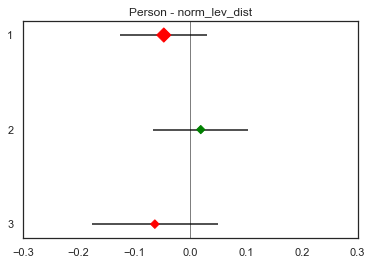

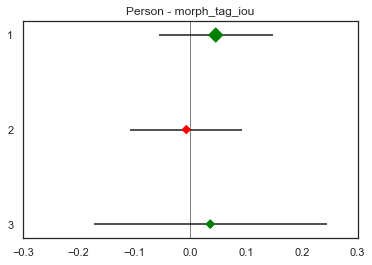

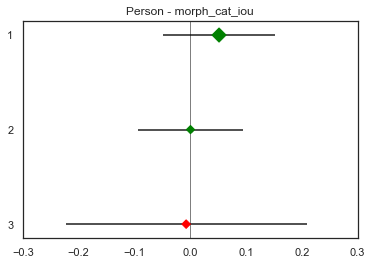

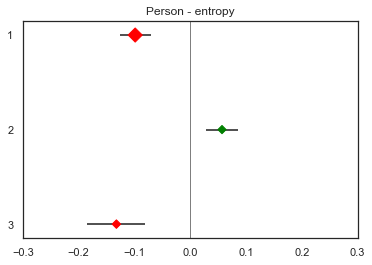

In [ ]:
cat = "Person"

tag_ce_agg_mean, tag_ce_agg_std, tag_N_pos = dict(), dict(), dict()
for tag in morph_cat_tag_vocab[cat]:
    if tag not in tag_lemmas.keys():
        continue

    weighted_mean, weighted_std, N_pos = get_ce_estimate(eval_data, lemmas_inverse_index, tag_lemmas, tag=tag, min_samples=0, min_var=1e-6, lemma_lim=1/64)

    tag_ce_agg_mean[tag] = weighted_mean
    tag_ce_agg_std[tag] = weighted_std
    tag_N_pos[tag] = N_pos

for metric in ["norm_lev_dist", "morph_tag_iou", "morph_cat_iou", "entropy"]:
    fig, ax = plt.subplots()

    tags = sorted(list(tag_ce_agg_mean.keys()))
    pos = np.arange(len(tags))

    means = [tag_ce_agg_mean[t][metric] for t in tags]
    error = [tag_ce_agg_std[t][metric] for t in tags]
    color = ["green" if m >= 0 else "red" for m in means]
    sizes = np.array([tag_N_pos[t] for t in tags])
    sizes = 100 * (sizes / sizes.max())

    ax.scatter(means, pos, marker="D", c=color, s=sizes, zorder=2)
    ax.errorbar(means, pos, xerr=error, fmt=".", c="k", zorder=1)

    ax.set_yticks(pos, labels=tags)
    ax.invert_yaxis()

    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(len(means)-0.85, -0.15)
    ax.vlines(x=0, ymin=-1, ymax=len(means)+1, color="black", linewidth=0.5, zorder=1)

    ax.set_title(f"{cat} - {metric}")

    plt.show()



In [56]:
cat = "Part of Speech"

tag_ce_agg_mean, tag_ce_agg_std, tag_N_pos = dict(), dict(), dict()
for tag in morph_cat_tag_vocab[cat]:
    if tag not in tag_lemmas.keys():
        continue

    weighted_mean, weighted_std, N_pos = get_ce_estimate(eval_data, lemmas_inverse_index, tag_lemmas, tag=tag, min_samples=10, min_var=1e-6)

    tag_ce_agg_mean[tag] = weighted_mean
    tag_ce_agg_std[tag] = weighted_std
    tag_N_pos[tag] = N_pos

for metric in ["norm_lev_dist", "chrf_1", "chrf_3", "morph_tag_iou", "morph_cat_iou", "morph_tag_iou_at_match", "entropy"]:
    fig, ax = plt.subplots()

    tags = sorted(list(tag_ce_agg_mean.keys()))
    pos = np.arange(len(tags))

    means = [tag_ce_agg_mean[t][metric] for t in tags]
    error = [tag_ce_agg_std[t][metric] for t in tags]
    color = ["green" if m >= 0 else "red" for m in means]
    sizes = np.array([tag_N_pos[t] for t in tags])
    sizes = 100 * (sizes / sizes.max())

    ax.scatter(means, pos, marker="D", c=color, s=sizes, zorder=2)
    ax.errorbar(means, pos, xerr=error, fmt=".", c="k", zorder=1)

    ax.set_yticks(pos, labels=tags)
    ax.invert_yaxis()

    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(len(means)-0.85, -0.15)
    ax.vlines(x=0, ymin=-1, ymax=len(means)+1, color="black", linewidth=0.5, zorder=1)

    ax.set_title(f"{cat} - {metric}")

    plt.show()


KeyboardInterrupt: 

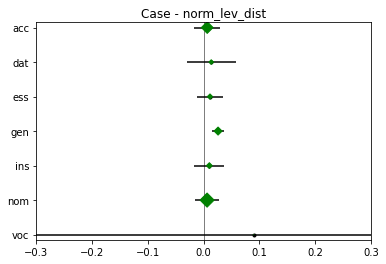

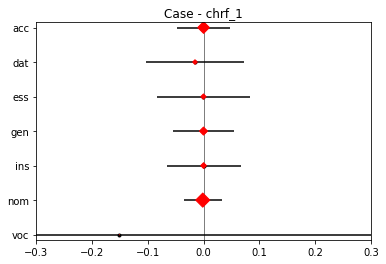

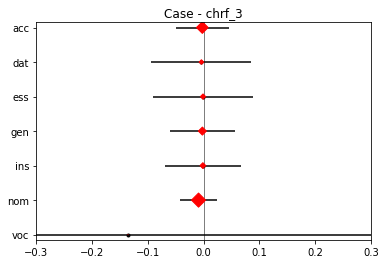

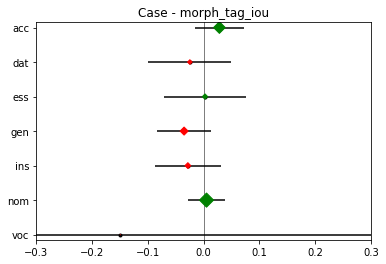

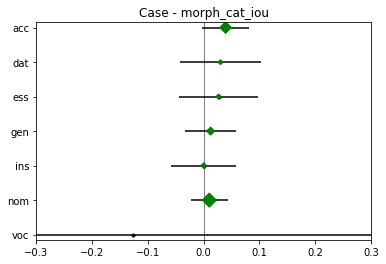

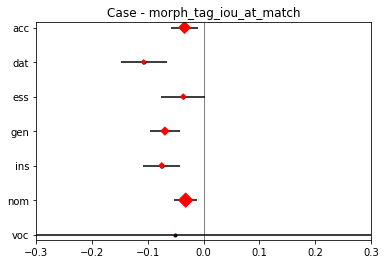

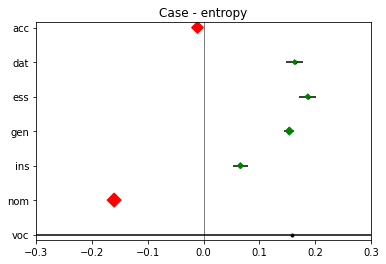

In [217]:
cat = "Case"

tag_ce_agg_mean, tag_ce_agg_std, tag_N_pos = dict(), dict(), dict()
for tag in morph_cat_tag_vocab[cat]:
    if tag not in tag_lemmas.keys():
        continue

    weighted_mean, weighted_std, N_pos = get_ce_estimate(eval_data, lemmas_inverse_index, tag_lemmas, tag=tag, min_samples=10, min_var=1e-6)

    tag_ce_agg_mean[tag] = weighted_mean
    tag_ce_agg_std[tag] = weighted_std
    tag_N_pos[tag] = N_pos

for metric in ["norm_lev_dist", "chrf_1", "chrf_3", "morph_tag_iou", "morph_cat_iou", "morph_tag_iou_at_match", "entropy"]:
    fig, ax = plt.subplots()

    tags = sorted(list(tag_ce_agg_mean.keys()))
    pos = np.arange(len(tags))

    means = [tag_ce_agg_mean[t][metric] for t in tags]
    error = [tag_ce_agg_std[t][metric] for t in tags]
    color = ["green" if m >= 0 else "red" for m in means]
    sizes = np.array([tag_N_pos[t] for t in tags])
    sizes = 100 * (sizes / sizes.max())

    ax.scatter(means, pos, marker="D", c=color, s=sizes, zorder=2)
    ax.errorbar(means, pos, xerr=error, fmt=".", c="k", zorder=1)

    ax.set_yticks(pos, labels=tags)
    ax.invert_yaxis()

    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(len(means)-0.85, -0.15)
    ax.vlines(x=0, ymin=-1, ymax=len(means)+1, color="black", linewidth=0.5, zorder=1)

    ax.set_title(f"{cat} - {metric}")

    plt.show()



In [90]:


lemma_results = []
for l in tag_lemmas[tag]:
    inclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() in set(tag_set) and "_" not in set(tag_set)]
    exclusive_examples = [tag_set for tag_set in lemmas_inverse_index[l] if tag.upper() not in set(tag_set) and "_" not in set(tag_set)]

    if len(inclusive_examples) == 0 or len(exclusive_examples) == 0:
        continue

    inclusive_stats = defaultdict(list)
    for tag_set in inclusive_examples:
        for instance in eval_data[tag_set][l]:
            for metric, metric_val in instance.items():
                if metric != "confusion":
                    inclusive_stats[metric].append(metric_val)
    inclusive_stats = dict(inclusive_stats)

    N_inclusive = len(list(inclusive_stats.values())[0])
    inclusive_stats = {k: np.mean(v) for k, v in inclusive_stats.items()}

    exclusive_stats = defaultdict(list)
    for tag_set in exclusive_examples:
        for instance in eval_data[tag_set][l]:
            for metric, metric_val in instance.items():
                if metric != "confusion":
                    exclusive_stats[metric].append(metric_val)
    exclusive_stats = dict(exclusive_stats)

    N_exclusive = len(list(exclusive_stats.values())[0])
    exclusive_stats = {k: np.mean(v) for k, v in exclusive_stats.items()}

    expected_difference = {k: v - exclusive_stats[k] for k, v in inclusive_stats.items()}

    lemma_results.append((N_inclusive + N_exclusive, expected_difference))

agg_counts = defaultdict(list)
agg_vals = defaultdict(list)
for count, stats in lemma_results:
    if micro_or_macro == "macro":
        count = 1
    for metric, metric_val in stats.items():
        agg_counts[metric] += [count]
        agg_vals[metric] += [metric_val]

agg_counts = dict(agg_counts)
agg_vals = dict(agg_vals)

agg_counts = {k: np.array(v) for k, v in agg_counts.items()}
agg_vals = {k: np.array(v) for k, v in agg_vals.items()}

return agg_counts, agg_vals


In [106]:
import os
from itertools import combinations
from collections import defaultdict

base_fp = "./nmt_adapt/eval/figures/220426_1444_English_Czech"

micro_or_macro = "micro"

cat_ce_agg_mean, cat_ce_agg_std = dict(), dict()
for cat in morph_cat_tag_vocab.keys():

    tag_ce_agg_mean, tag_ce_agg_std = dict(), dict()
    for tag in morph_cat_tag_vocab[cat]:
        if tag not in tag_lemmas.keys():
            continue

        ce_agg_counts, ce_agg_vals = get_ce_estimate(
            eval_data,
            lemmas_inverse_index,
            tag_lemmas,
            tag=tag,
            micro_or_macro=micro_or_macro,
        )

        ce_agg_mean, ce_agg_std = dict(), dict()
        for metric in ce_agg_counts.keys():
            weighted_mean = (ce_agg_counts[metric] * ce_agg_vals[metric]).sum() / ce_agg_counts[metric].sum()
            weighted_std = np.sqrt((ce_agg_counts[metric] * np.power(ce_agg_vals[metric] - weighted_mean, 2)).sum() / \
                (ce_agg_counts[metric].sum() - np.power(ce_agg_counts[metric], 2).sum() / ce_agg_counts[metric].sum()))

            ce_agg_mean[metric] = weighted_mean
            ce_agg_std[metric] = weighted_std

        tag_ce_agg_mean[tag] = ce_agg_mean
        tag_ce_agg_std[tag] = ce_agg_std

    cat_ce_agg_mean[cat] = tag_ce_agg_mean
    cat_ce_agg_std[cat] = tag_ce_agg_std


In [109]:
for cat in morph_cat_tag_vocab.keys():
    tag_ce_agg_mean = cat_ce_agg_mean[cat]
    tag_ce_agg_std = cat_ce_agg_std[cat]

    if len(tag_ce_agg_mean) == 0:
        continue

    for metric in list(list(tag_ce_agg_mean.values())[0].keys()):
        fig, ax = plt.subplots()

        tags = sorted(list(tag_ce_agg_mean.keys()))
        pos = np.arange(len(tags))

        means = [tag_ce_agg_mean[t][metric] for t in tags]
        error = [tag_ce_agg_std[t][metric] for t in tags]
        color = ["green" if m >= 0 else "red" for m in means]

        ax.scatter(means, pos, marker="D", c=color, s=100, zorder=2)
        ax.errorbar(means, pos, xerr=error, fmt=".", c="k", zorder=1)
        ax.set_yticks(pos, labels=tags)
        ax.invert_yaxis()
        ax.set_title(f"{cat} - {metric}")

        os.makedirs(base_fp + f"/{cat}", exist_ok=True)
        fig.savefig(
            f"{base_fp}/{cat}/{metric}_ce.pdf"
        )
        print(f"{base_fp}/{cat}/{metric}_ce.pdf")

        plt.close(fig)


./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/char_match_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/lev_dist_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/norm_lev_dist_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_1_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_2_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_3_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_4_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/chrf_5_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/spe_match_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/spe_lev_dist_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/spe_norm_lev_dist_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/lemma_match_ce.pdf
./nmt_adapt/eval/figures/220426_1444_English_Czech/Person/lemma_norm_lev_dist_ce.pdf
./nmt_adapt/e

In [67]:
morph_cat_tag_vocab.keys()

dict_keys(['Person', 'Tense', 'Comparison', 'Case', 'Deixis', 'Aktionsart', 'Voice', 'Part of Speech', 'Mood', 'Possession', 'Animacy', 'Valency', 'Argument Marking', 'Evidentiality', 'Politeness', 'Gender', 'Switch-Reference', 'Interrogativity', 'Definiteness', 'Number', 'Finiteness', 'Information Structure', 'Aspect', 'Language-Specific Features ', 'Polarity'])

# Confusion Matrix

In [ ]:
#from morphological_tagging.data.corpus import TreebankDataModule

#dm = TreebankDataModule.load("./morphological_tagging/data/corpora/")

In [1]:
from nmt_adapt.marginal_task import MarginalTask
from nmt_adapt.inverse_index import InverseIndexv2
from nmt_adapt.task_sampling import build_confusion_matrix_from_eval_data, TaskSampler

index = InverseIndexv2.load("./nmt_adapt/data/indices/ataman_multidomain_english_czech_train.pickle")
index.filter(lambda k: not k.contains("_"))

task_sampler = TaskSampler(index)
present_keys = {(frozenset(t1.morph_tag_set), frozenset(t2.morph_tag_set)) for t1, t2 in list(task_sampler.lemma_intersection.keys())}
del task_sampler

confusion_matrix = build_confusion_matrix_from_eval_data("./nmt_adapt/eval/220426_1444_English_Czech.pickle")


In [2]:
from collections import defaultdict
from itertools import product

marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            tags_not_in_t2 = list(t1 - t2)
            tags_not_in_t1 = list(t2 - t1)
            Z = len(tags_not_in_t2) * len(tags_not_in_t1)
            for tt1, tt2 in product(tags_not_in_t2, tags_not_in_t1):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

In [10]:
import pickle
import json

cat_order = [
    "Part of Speech",
    "Case",
    "Gender",
    "Animacy",
    "Number",
    "Aspect",
    "Finiteness",
    "Mood",
    "Tense",
    "Voice",
    "Comparison",
    "Polarity",
    "Person"
]

with open("./morphological_tagging/data/uni_morph_tags.json", "rb") as f:
        uni_morph_tags = json.load(f)

morph_tag_vocab = {
    feat: long_feat for feat, [long_feat, _] in uni_morph_tags.items()
}

morph_tag_cat_vocab = {
    feat: cat for feat, [_, cat] in uni_morph_tags.items()
}

morph_cat_tag_vocab = defaultdict(set)
for k, v in morph_tag_cat_vocab.items():
    morph_cat_tag_vocab[v].add(k)
morph_cat_tag_vocab = dict(morph_cat_tag_vocab)

all_tags = list(map(lambda x: x.lower(), list(marginal_confusion_matrix.keys())))

local_morph_cat_tag_vocab = {cat: sorted([tag for tag in tags if tag in all_tags]) for cat, tags in morph_cat_tag_vocab.items()}
local_morph_cat_tag_vocab = {cat: tags for cat, tags in local_morph_cat_tag_vocab.items() if len(tags) > 0}
sorted_local_morph_cat_tag_vocab = [(cat, local_morph_cat_tag_vocab[cat]) for cat in cat_order]
n_cats = len(sorted_local_morph_cat_tag_vocab)
local_all_tags = [tag for cat, tags in sorted_local_morph_cat_tag_vocab for tag in tags]
n_tags = len(local_all_tags)

In [11]:
tag_to_int = {
    tag: i for i, tag in enumerate(local_all_tags)
}

int_to_tag = {v: k for k, v in tag_to_int.items()}

## Transpositions Only

In [122]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def plot_confusion_matrix(
    marginal_confusion_array,
    title,
    figsize=(12, 12),
    default_fontsize=16,
    cycle_len=3,
    cmap: str = "tab10",
    fill_cmap: str = "viridis",
    fudge_factor: float = 0.005,
    y_rotation: float = 0,
    x_rotation: float = 90,
    gridlines: float = 0.5,
    edgecolor="k",
    show_x_labels: bool = True,
    ):

    cmap = sns.mpl_palette(cmap, cycle_len)

    fill_cmap = matplotlib.cm.get_cmap(fill_cmap).copy()
    fill_cmap.set_bad('white', 1.0)

    fig = plt.figure(figsize=figsize)

    vmin, vmax = np.quantile(marginal_confusion_array, q=[fudge_factor, 1-fudge_factor])

    def imshow_(ax, data):
        ax.pcolormesh(
            data,
            vmin=vmin,
            vmax=vmax,
            cmap=fill_cmap,
            edgecolors=edgecolor,
            linewidth=gridlines,
            #rasterized=True,
            )

        ax.invert_yaxis()

    gs = gridspec.GridSpec(n_tags, n_tags, figure=fig)

    axes = []
    block_size = 0
    for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab):

        h0, h1 = block_size, block_size+len(tags)

        if i != 0:
            ax = fig.add_subplot(gs[h0:h1, 0:block_size])
            imshow_(ax, marginal_confusion_array[h0:h1, 0:block_size])
            if i % 2 == 0 or (len(sorted_local_morph_cat_tag_vocab) % 2 == 1 and i == len(sorted_local_morph_cat_tag_vocab) - 1):
                ax.set_ylabel(
                    f"{cat}",
                    fontsize=default_fontsize+4,
                    color=cmap[i%cycle_len],
                    rotation=y_rotation,
                    ha="right",
                    va="center",
                    )
            axes.append(ax)

        ax = fig.add_subplot(gs[h0:h1, block_size:block_size+len(tags)])
        imshow_(ax, marginal_confusion_array[h0:h1, block_size:block_size+len(tags)])
        if i == 0:
            ax.set_ylabel(
                f"{cat}",
                fontsize=default_fontsize+4,
                color=cmap[i%cycle_len],
                rotation=y_rotation,
                ha="right",
                va="center",
                )
        #ax.plot([1,0], [0,1], transform=ax.transAxes, c="white", linewidth=4)
        axes.append(ax)

        if i != len(sorted_local_morph_cat_tag_vocab) - 1:
            ax = fig.add_subplot(gs[h0:h1, block_size+len(tags):])
            imshow_(ax, marginal_confusion_array[h0:h1, block_size+len(tags):])
            axes.append(ax)
            if i % 2 == 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(
                    f"{cat}",
                    fontsize=default_fontsize+4,
                    color=cmap[i%cycle_len],
                    rotation=y_rotation,
                    ha="left",
                    va="center",
                    )

        block_size += len(tags)

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

    if show_x_labels:
        axes[-2].set_xticks(np.arange(0.5, block_size-len(tags) + 0.5, 1))
        axes[-2].set_xticklabels(
            [morph_tag_vocab[tag] for tag in local_all_tags[:-len(tags)]],
            rotation=x_rotation,
            ha="center",
            fontsize=default_fontsize,
            )

        ticks = axes[-2].get_xticklabels()

        cum_cat_len = 0
        for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab[:-1]):
            for tick in ticks[cum_cat_len:cum_cat_len+len(tags)]:
                tick.set_color(cmap[i%cycle_len])
            cum_cat_len += len(tags)

        last_cat_len = len(sorted_local_morph_cat_tag_vocab[-1][1])
        axes[-1].set_xticks(np.arange(0.5, last_cat_len + 0.5, 1))
        axes[-1].set_xticklabels(
            [morph_tag_vocab[tag] for tag in local_all_tags[-last_cat_len:]],
            rotation=x_rotation,
            ha="center",
            fontsize=default_fontsize,
            )

        for tick in axes[-1].get_xticklabels():
            tick.set_color(cmap[(n_cats-1)%cycle_len])

    gs.update(left=None, right=None, bottom=None, top=None, wspace=None, hspace=None)

    fig.text(-0.06, 0.50, title, va='center', rotation='vertical', fontsize=default_fontsize+6)
    #fig.text(0.08, 0.50, 'Ground Truth', va='center', rotation='vertical', fontsize=24)
    #fig.text(0.50, 0.90, title, ha='center', fontsize=16)

    return fig

In [143]:
from collections import defaultdict
from itertools import product, combinations

import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================
marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            tags_not_in_t2 = list(t1 - t2)
            tags_not_in_t1 = list(t2 - t1)
            Z = len(tags_not_in_t2) * len(tags_not_in_t1)
            for tt1, tt2 in product(tags_not_in_t2, tags_not_in_t1):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

marginal_confusion_array = np.zeros((len(tag_to_int), len(tag_to_int)))

for t1, t2 in combinations(list(tag_to_int), 2):
    marginal_confusion_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_confusion_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_confusion_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_confusion_matrix[t2.upper()].get(t1.upper(), [0]))

marginal_confusion_array_ = (marginal_confusion_array) / np.sum(marginal_confusion_array, axis=0)


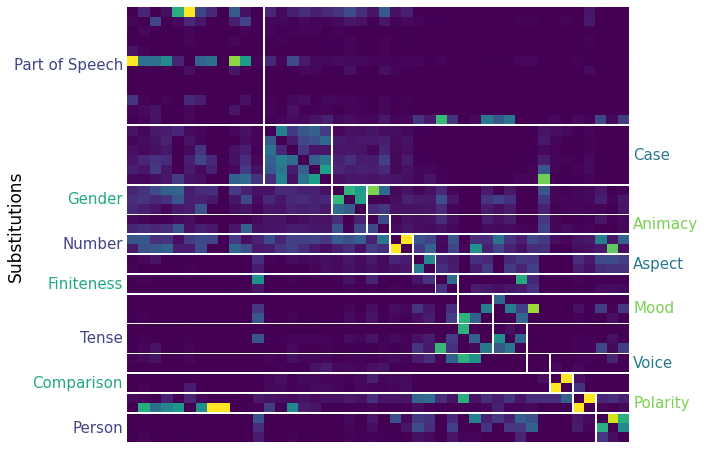

In [144]:
fig = plot_confusion_matrix(marginal_confusion_array_, "Substitutions", cmap="viridis", fill_cmap="viridis", gridlines=0, edgecolor="w", default_fontsize=11, figsize=(9, 8), cycle_len=4, show_x_labels=False)

In [145]:
fig.savefig("../msc_thesis_write/images/substitutions.pdf", bbox_inches="tight")

In [146]:
marginal_confusion_array_.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## False Positives

In [147]:
from collections import defaultdict
from itertools import product, combinations

import matplotlib.pyplot as plt

# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================
marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            false_positives = list(t2 - t1)

            Z = len(list(t1)) * len(false_positives)
            for tt1, tt2 in product(list(t1), false_positives):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

marginal_confusion_array = np.zeros((len(tag_to_int), len(tag_to_int)))

for t1, t2 in combinations(list(tag_to_int), 2):
    marginal_confusion_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_confusion_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_confusion_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_confusion_matrix[t2.upper()].get(t1.upper(), [0]))

marginal_confusion_array_ = (marginal_confusion_array) / np.sum(marginal_confusion_array, axis=0)


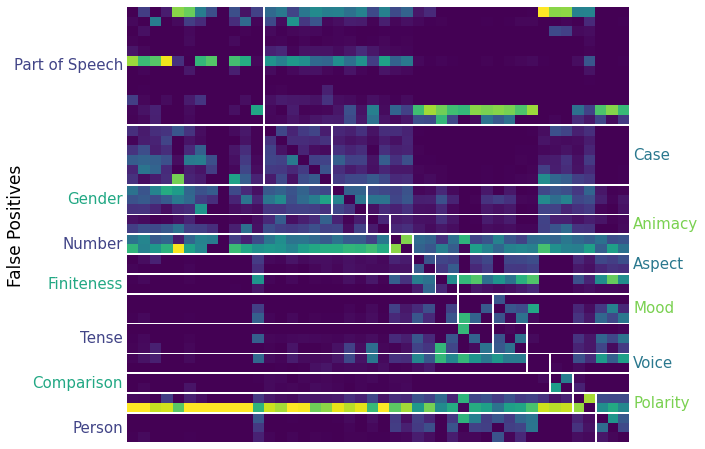

In [148]:
fig = plot_confusion_matrix(marginal_confusion_array_, "False Positives", fill_cmap="viridis", gridlines=0, edgecolor="w", default_fontsize=11, figsize=(9, 8), cmap="viridis", cycle_len=4, show_x_labels=False)

In [149]:
fig.savefig("../msc_thesis_write/images/false_positives.pdf", bbox_inches="tight")

In [150]:
marginal_confusion_array_.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## False Negatives

In [151]:
from collections import defaultdict
from itertools import product, combinations

import matplotlib.pyplot as plt

# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================
marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            false_negatives = list(t1 - t2)

            Z = len(false_negatives) * len(list(t2))
            for tt1, tt2 in product(false_negatives, list(t2)):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

marginal_confusion_array = np.zeros((len(tag_to_int), len(tag_to_int)))

for t1, t2 in combinations(list(tag_to_int), 2):
    marginal_confusion_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_confusion_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_confusion_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_confusion_matrix[t2.upper()].get(t1.upper(), [0]))

marginal_confusion_array_ = (marginal_confusion_array) / np.sum(marginal_confusion_array, axis=0)


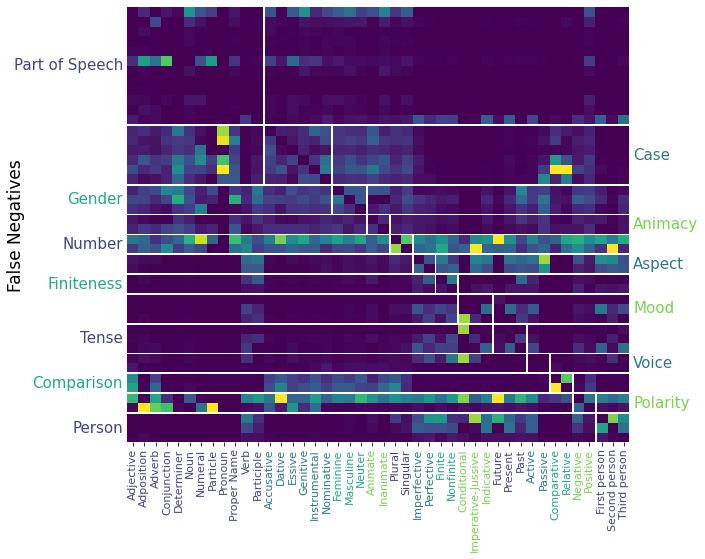

In [152]:
fig = plot_confusion_matrix(marginal_confusion_array_, "False Negatives", fill_cmap="viridis", gridlines=0, edgecolor="w", default_fontsize=11, figsize=(9, 8), cmap="viridis", cycle_len=4, show_x_labels=True)

In [153]:
fig.savefig("../msc_thesis_write/images/false_negatives.pdf", bbox_inches="tight")

In [154]:
marginal_confusion_array_.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Hamming Distance

In [548]:
from collections import defaultdict
from itertools import product, combinations

import matplotlib.pyplot as plt

# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================
marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
marginal_weights_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            false_positives = list(t2 - t1)
            false_negatives = list(t1 - t2)

            Z = len(list(t1)) * len(list(t2))
            for tt1, tt2 in product(list(t1), list(t2)):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z * (len(false_positives) + len(false_negatives))]
                marginal_weights_matrix[tt1][tt2] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

marginal_weights_matrix = dict(marginal_weights_matrix)
for k, v in marginal_weights_matrix.items():
    marginal_weights_matrix[k] = dict(v)

marginal_confusion_array = np.zeros((len(tag_to_int), len(tag_to_int)))
marginal_weights_array = np.zeros((len(tag_to_int), len(tag_to_int)))

for t1, t2 in combinations(list(tag_to_int), 2):
    marginal_confusion_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_confusion_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_confusion_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_confusion_matrix[t2.upper()].get(t1.upper(), [0]))

    marginal_weights_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_weights_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_weights_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_weights_matrix[t2.upper()].get(t1.upper(), [0]))

marginal_confusion_array_ = marginal_confusion_array / marginal_weights_array
marginal_confusion_array_ = np.nan_to_num(marginal_confusion_array_, 0)

C:\Users\ivoon\AppData\Local\Temp/ipykernel_13604/3464324557.py:40: RuntimeWarning: invalid value encountered in true_divide
  marginal_confusion_array_ = marginal_confusion_array / marginal_weights_array


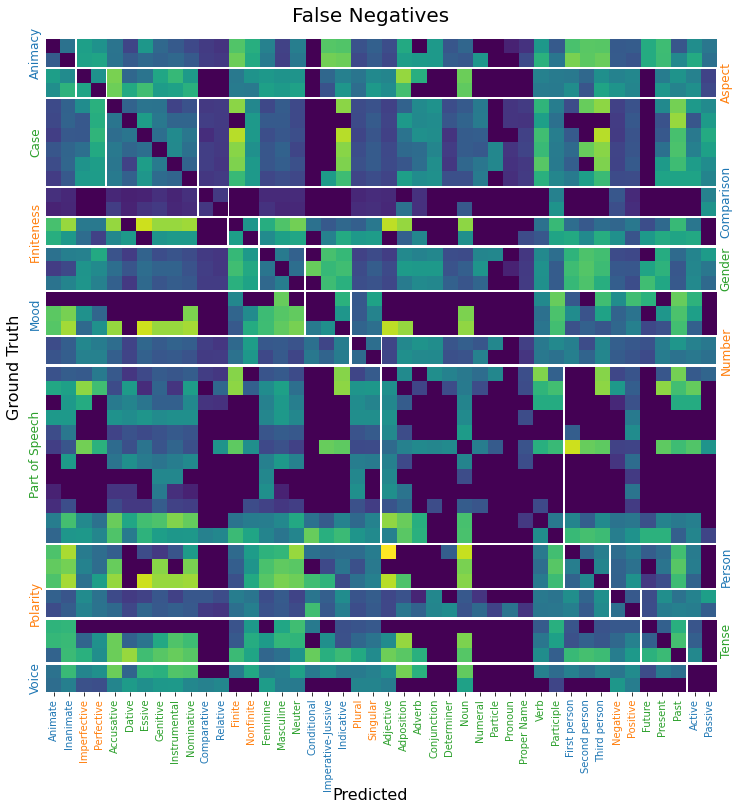

In [549]:
# ==============================================================================
# PLOTTING CODE
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

cycle_len = 3
cmap = sns.mpl_palette("tab10", cycle_len)

fig = plt.figure(figsize=(12, 12))

fudge_factor = 0
vmin, vmax = np.quantile(marginal_confusion_array_, q=[fudge_factor, 1-fudge_factor])

def imshow_(ax, data):
    ax.imshow(
        data,
        vmin=vmin,
        vmax=vmax,
        aspect="auto",
        )

gs = gridspec.GridSpec(n_tags, n_tags, figure=fig)

axes = []
block_size = 0
for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab):

    h0, h1 = block_size, block_size+len(tags)

    if i != 0:
        ax = fig.add_subplot(gs[h0:h1, 0:block_size])
        imshow_(ax, marginal_confusion_array_[h0:h1, 0:block_size])
        if i % 2 == 0 or (len(sorted_local_morph_cat_tag_vocab) % 2 == 1 and i == len(sorted_local_morph_cat_tag_vocab) - 1):
            ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])
        axes.append(ax)

    ax = fig.add_subplot(gs[h0:h1, block_size:block_size+len(tags)])
    imshow_(ax, marginal_confusion_array_[h0:h1, block_size:block_size+len(tags)])
    if i == 0:
        ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])
    axes.append(ax)

    if i != len(sorted_local_morph_cat_tag_vocab) - 1:
        ax = fig.add_subplot(gs[h0:h1, block_size+len(tags):])
        imshow_(ax, marginal_confusion_array_[h0:h1, block_size+len(tags):])
        axes.append(ax)
        if i % 2 == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])

    block_size += len(tags)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-2].set_xticks(list(range(block_size-len(tags))))
axes[-2].set_xticklabels(
    [morph_tag_vocab[tag] for tag in local_all_tags[:-len(tags)]],
    rotation=90,
    ha="center",
    )

ticks = axes[-2].get_xticklabels()

cum_cat_len = 0
for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab[:-1]):
    for tick in ticks[cum_cat_len:cum_cat_len+len(tags)]:
        tick.set_color(cmap[i%cycle_len])
    cum_cat_len += len(tags)

last_cat_len = len(sorted_local_morph_cat_tag_vocab[-1][1])
axes[-1].set_xticks(list(range(last_cat_len)))
axes[-1].set_xticklabels(
    [morph_tag_vocab[tag] for tag in local_all_tags[-last_cat_len:]],
    rotation=90,
    ha="center",
    )

for tick in axes[-1].get_xticklabels():
    tick.set_color(cmap[(n_cats-1)%cycle_len])

gs.update(left=None, right=None, bottom=None, top=None, wspace=None, hspace=None)

fig.text(0.50, 0.00, 'Predicted', ha='center', fontsize=16)
fig.text(0.08, 0.50, 'Ground Truth', va='center', rotation='vertical', fontsize=16)
fig.text(0.50, 0.90, 'False Negatives', ha='center', fontsize=20)

plt.show()


## Any Mistake

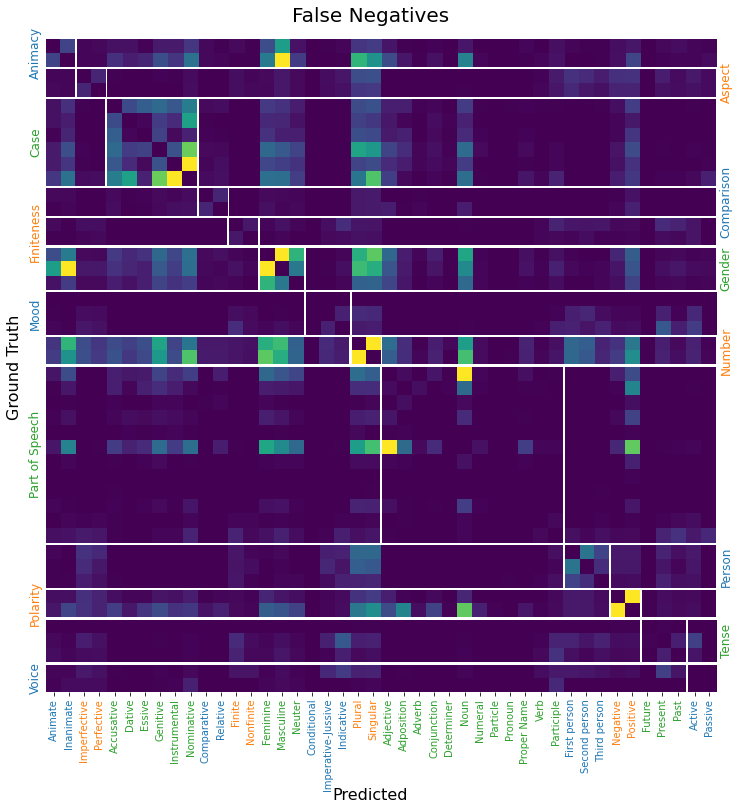

In [13]:
import math
from collections import defaultdict
from itertools import product, combinations

import matplotlib.pyplot as plt

# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================
marginal_confusion_matrix = defaultdict(lambda: defaultdict(list))
for t1, subdict in confusion_matrix.items():
    for t2, prob in subdict.items():
        if (("_" not in t1) and ("_" not in t2)) and ((t1, t2) in present_keys or (t2, t1) in present_keys):
            mistakes = set.union(set(t1), set(t2)) - set.intersection(set(t1), set(t2))

            Z = 2 * math.comb(len(mistakes), 2)
            for tt1, tt2 in combinations(list(mistakes), r=2):
                marginal_confusion_matrix[tt1][tt2] += [prob / Z]
                marginal_confusion_matrix[tt2][tt1] += [prob / Z]

marginal_confusion_matrix = dict(marginal_confusion_matrix)
for k, v in marginal_confusion_matrix.items():
    marginal_confusion_matrix[k] = dict(v)

marginal_confusion_array = np.zeros((len(tag_to_int), len(tag_to_int)))

for t1, t2 in combinations(list(tag_to_int), 2):
    marginal_confusion_array[tag_to_int[t1]][tag_to_int[t2]] = np.sum(marginal_confusion_matrix[t1.upper()].get(t2.upper(), [0]))
    marginal_confusion_array[tag_to_int[t2]][tag_to_int[t1]] = np.sum(marginal_confusion_matrix[t2.upper()].get(t1.upper(), [0]))

marginal_confusion_array_ = (marginal_confusion_array) / np.sum(marginal_confusion_array)

# ==============================================================================
# PLOTTING CODE
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

cycle_len = 3
cmap = sns.mpl_palette("tab10", cycle_len)

fig = plt.figure(figsize=(12, 12))

all_tags = set(tag_to_int.keys())
local_morph_cat_tag_vocab = {cat: sorted([tag for tag in tags if tag in all_tags]) for cat, tags in morph_cat_tag_vocab.items()}
local_morph_cat_tag_vocab = {cat: tags for cat, tags in local_morph_cat_tag_vocab.items() if len(tags) > 0}
sorted_local_morph_cat_tag_vocab = sorted(local_morph_cat_tag_vocab.items(), key=lambda x: x[0])
n_cats = len(sorted_local_morph_cat_tag_vocab)
local_all_tags = [tag for cat, tags in sorted_local_morph_cat_tag_vocab for tag in tags]
n_tags = len(local_all_tags)

fudge_factor = 0.005
vmin, vmax = np.quantile(marginal_confusion_array_, q=[fudge_factor, 1-fudge_factor])

def imshow_(ax, data):
    ax.imshow(
        data,
        vmin=vmin,
        vmax=vmax,
        aspect="auto",
        )

gs = gridspec.GridSpec(n_tags, n_tags, figure=fig)

axes = []
block_size = 0
for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab):

    h0, h1 = block_size, block_size+len(tags)

    if i != 0:
        ax = fig.add_subplot(gs[h0:h1, 0:block_size])
        imshow_(ax, marginal_confusion_array_[h0:h1, 0:block_size])
        if i % 2 == 0 or (len(sorted_local_morph_cat_tag_vocab) % 2 == 1 and i == len(sorted_local_morph_cat_tag_vocab) - 1):
            ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])
        axes.append(ax)

    ax = fig.add_subplot(gs[h0:h1, block_size:block_size+len(tags)])
    imshow_(ax, marginal_confusion_array_[h0:h1, block_size:block_size+len(tags)])
    if i == 0:
        ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])
    axes.append(ax)

    if i != len(sorted_local_morph_cat_tag_vocab) - 1:
        ax = fig.add_subplot(gs[h0:h1, block_size+len(tags):])
        imshow_(ax, marginal_confusion_array_[h0:h1, block_size+len(tags):])
        axes.append(ax)
        if i % 2 == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{cat}", fontsize=12, color=cmap[i%cycle_len])

    block_size += len(tags)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-2].set_xticks(list(range(block_size-len(tags))))
axes[-2].set_xticklabels(
    [morph_tag_vocab[tag] for tag in local_all_tags[:-len(tags)]],
    rotation=90,
    ha="center",
    )

ticks = axes[-2].get_xticklabels()

cum_cat_len = 0
for i, (cat, tags) in enumerate(sorted_local_morph_cat_tag_vocab[:-1]):
    for tick in ticks[cum_cat_len:cum_cat_len+len(tags)]:
        tick.set_color(cmap[i%cycle_len])
    cum_cat_len += len(tags)

last_cat_len = len(sorted_local_morph_cat_tag_vocab[-1][1])
axes[-1].set_xticks(list(range(last_cat_len)))
axes[-1].set_xticklabels(
    [morph_tag_vocab[tag] for tag in local_all_tags[-last_cat_len:]],
    rotation=90,
    ha="center",
    )

for tick in axes[-1].get_xticklabels():
    tick.set_color(cmap[(n_cats-1)%cycle_len])

gs.update(left=None, right=None, bottom=None, top=None, wspace=None, hspace=None)

fig.text(0.50, 0.00, 'Predicted', ha='center', fontsize=16)
fig.text(0.08, 0.50, 'Ground Truth', va='center', rotation='vertical', fontsize=16)
fig.text(0.50, 0.90, 'False Negatives', ha='center', fontsize=20)

plt.show()


In [581]:
list(combinations(list(mistakes), r=2))

[('POS', 'FEM'),
 ('POS', '{FEM/NEUT}'),
 ('POS', '{PL/SG}'),
 ('POS', 'NEUT'),
 ('POS', 'NEG'),
 ('FEM', '{FEM/NEUT}'),
 ('FEM', '{PL/SG}'),
 ('FEM', 'NEUT'),
 ('FEM', 'NEG'),
 ('{FEM/NEUT}', '{PL/SG}'),
 ('{FEM/NEUT}', 'NEUT'),
 ('{FEM/NEUT}', 'NEG'),
 ('{PL/SG}', 'NEUT'),
 ('{PL/SG}', 'NEG'),
 ('NEUT', 'NEG')]

In [580]:
math.comb(len(mistakes), 2)

15

In [477]:
import pandas as pd

records = []
for t1, tt in enumerate(np.argpartition(marginal_confusion_array_, -5, axis=1)[:, -5:]):
    record = {}
    record |= {"gt": int_to_tag[t1]}

    mistakes = list(map(list, zip(*sorted([(int_to_tag[t2], marginal_confusion_array_[t1][t2]) for t2 in tt], key=lambda x: x[1], reverse=True))))
    for i in range(len(mistakes[0])):
        records.append(record | {"predicted": mistakes[0][i], "prob": mistakes[1][i]})

mistakes = pd.DataFrame.from_records(records)

mistakes.sort_values("prob", ascending=False)

,gt,predicted,prob
190,pos,part,0.607106
115,adp,pro,0.498460
191,pos,pro,0.417374
192,pos,propn,0.282276
193,pos,v,0.248586
...,...,...,...
88,cond,neg,0.000062
89,cond,3,0.000058
147,part,ins,0.000007
148,part,fem,0.000006


# JASP Export

In [4]:
import math

import numpy as np
import pandas as pd

from nmt_adapt.data.corpus_functional import load_custom_dataset

In [5]:
all_morph_tags = sorted({morph_tag for morph_tag_set in eval_data.keys() for morph_tag in list(morph_tag_set)})
all_morph_cats = sorted({morph_tag_cat_vocab.get(tag.lower(), "_") for tag in all_morph_tags} - {"_"})
morph_tag_to_int = {morph_tag: i for i, morph_tag in enumerate(all_morph_tags)}
int_to_morph_tag = {i: morph_tag for morph_tag, i in morph_tag_to_int.items()}

In [ ]:
records = []
for morph_tag_set in eval_data.keys():

    present_morph_cats = {morph_tag_cat_vocab.get(tag.lower(), "_") for tag in all_morph_tags for tag in list(morph_tag_set)} - {"_"}

    if len(present_morph_cats) == 0:
        continue

    for lemma, instances in eval_data[morph_tag_set].items():
        for instance in instances:
            record = {
                "lemma_match": instance["lemma_match"],
                "norm_lev_dist": instance["norm_lev_dist"],
                "chrf_2": instance["chrf_2"],
                "chrf_3": instance["chrf_3"],
                "morph_tag_iou": instance["morph_tag_iou"],
                "morph_cat_iou": instance["morph_cat_iou"],
                "entropy": instance["entropy"],
                "approx_unique_samples": math.exp(instance["entropy"]),
                }

            morph_tag_freqs = np.array(list(instance["confusion"].values()))
            morph_tag_rel_freqs = morph_tag_freqs / morph_tag_freqs.sum()

            morph_tag_entropy = - np.sum(morph_tag_rel_freqs * np.log(morph_tag_rel_freqs))
            morph_tag_expected_unique = np.exp(morph_tag_entropy)
            morph_tag_unique = len(morph_tag_freqs)

            morph_cat_acc, weights = 0, 0
            for pred_tag_set, count in instance["confusion"].items():
                intersection = frozenset.intersection(morph_tag_set, pred_tag_set)

                morph_cat_acc_ = {morph_tag_cat_vocab.get(tag.lower()) for tag in intersection}
                morph_cat_acc_ = len(morph_cat_acc_) / len(present_morph_cats)

                morph_cat_acc += count * morph_cat_acc_
                weights += count

            morph_cat_acc = morph_cat_acc / weights

            record |= {
                "morph_tag_entropy": morph_tag_entropy,
                "morph_tag_expected_unique": morph_tag_expected_unique,
                "morph_tag_unique": morph_tag_unique,
                "morph_cat_acc": morph_cat_acc,
            }

            record_tags = {f"{morph_tag_cat_vocab.get(tag.lower())} - {morph_tag_vocab.get(tag.lower())}": float(tag in morph_tag_set) for tag in all_morph_tags}
            record_tags = dict(sorted(record_tags.items(), key=lambda x: x[0]))
            record |= record_tags

            record |= {cat: float(cat in present_morph_cats) for cat in all_morph_cats}

            records.append(record)


In [8]:
records[0]

{'lemma_match': 0.0,
 'norm_lev_dist': 0.7583333333333333,
 'chrf_2': 0.13541666666666666,
 'chrf_3': 0.0,
 'morph_tag_iou': 0.047619047619047616,
 'morph_cat_iou': 0.2708333333333333,
 'entropy': 1.850983694881109,
 'approx_unique_samples': 6.36607872257775,
 'morph_tag_entropy': 1.2830041293692707,
 'morph_tag_expected_unique': 3.607460742328557,
 'morph_tag_unique': 5,
 'morph_cat_acc': 0.05555555555555555,
 'Animacy - Animate': 0.0,
 'Animacy - Inanimate': 1.0,
 'Aspect - Imperfective': 0.0,
 'Aspect - Perfective': 0.0,
 'Case - Accusative': 0.0,
 'Case - Dative': 0.0,
 'Case - Essive': 0.0,
 'Case - Genitive': 0.0,
 'Case - Instrumental': 0.0,
 'Case - Nominative': 1.0,
 'Case - Vocative': 0.0,
 'Comparison - Comparative': 0.0,
 'Comparison - Relative': 0.0,
 'Finiteness - Finite': 0.0,
 'Finiteness - Nonfinite': 0.0,
 'Gender - Feminine': 0.0,
 'Gender - Masculine': 1.0,
 'Gender - Neuter': 0.0,
 'Mood - Conditional': 0.0,
 'Mood - Imperative-Jussive': 0.0,
 'Mood - Indicative': 

In [7]:
df = pd.DataFrame.from_records(records)

df.to_csv(
    f"./nmt_adapt/eval/datasets/{file_name}.csv",
    index=False,
)

## Hierarchical v3

In [6]:
from collections import defaultdict
from itertools import combinations

occurences = defaultdict(int)
pos_co_occurences = defaultdict(lambda: defaultdict(int))
co_occurences = defaultdict(lambda: defaultdict(int))
for k in list(eval_data.keys()):
    PoSes = []
    others = []
    for kk in list(k):
        cat = morph_tag_cat_vocab.get(kk.lower(), "_")
        if cat == "Part of Speech":
            PoSes.append(kk)
        else:
            others.append(cat)

    if len(PoSes) == 0:
        continue

    count = sum(map(lambda x: len(x[1]), eval_data[k].items()))

    if "V.PTCP" in PoSes and len(PoSes) == 2:
        if "V" in PoSes:
            pos = "V.PTCP"
        elif "ADJ" in PoSes:
            pos = "ADJ.PTCP"

    elif len(PoSes) == 1:
        pos = PoSes[0]

    else:
        pos = None

    if pos is not None:
        occurences[pos] += count
        for other in others:
            co_occurences[pos][other] += count

    if len(PoSes) > 1:
        for pos1, pos2 in combinations(PoSes, 2):
            pos_co_occurences[pos1][pos2] += count
            pos_co_occurences[pos2][pos1] += count

occurences = dict(occurences)
co_occurences = dict(co_occurences)
for k, subdict in co_occurences.items():
    subdict_ = dict()
    for kk, co_occurence in sorted(subdict.items(), key=lambda x: x[1], reverse=True):
        p = co_occurence / occurences[k]
        if p >= 0.10 and kk != "_":
            subdict_[kk] = p
        elif kk == "Animacy" and subdict_.get("Gender", 0.0) >= 0.05:
            subdict_[kk] = p

    co_occurences[k] = subdict_


In [7]:
pos_co_occurences = dict(pos_co_occurences)
for k, subdict in pos_co_occurences.items():
    pos_co_occurences[k] = dict(subdict)
    for kk, co_occurence in subdict.items():
        pos_co_occurences[k][kk] = co_occurence / occurences[k]


In [8]:
sorted([(k, sum(subdict.values())) for k, subdict in pos_co_occurences.items()], key=lambda x: x[1], reverse=True)

[('V.PTCP', 2.329867753472511),
 ('PART', 0.8359469240048251),
 ('CONJ', 0.7043294614572333),
 ('ADV', 0.6242576518958428),
 ('V', 0.3826101869319156),
 ('ADJ', 0.29920800696257616),
 ('PROPN', 0.09682213438735178),
 ('PRO', 0.07961134343043892),
 ('ADP', 0.073242948418264),
 ('NUM', 0.06144578313253012),
 ('N', 0.05619740218301714),
 ('DET', 0.05524021158909205)]

In [9]:
cats_to_keep_per_pos = {pos: co_occurences[pos] for pos, _ in sorted(occurences.items(), key=lambda x: x[1], reverse=True)[:-2]}

In [10]:
records = []
for i, morph_tag_set in enumerate(eval_data.keys()):
    present_morph_cats = {morph_tag_cat_vocab.get(tag.lower(), "_") for tag in all_morph_tags for tag in list(morph_tag_set)} - {"_"}

    if len(present_morph_cats) == 0:
        continue

    # Find the part-of-speech of the tagset
    # Also takes into account the compound PoS that is a participle
    PoSes = [tag for tag in list(morph_tag_set) if morph_tag_cat_vocab.get(tag.lower(), "_") == "Part of Speech"]

    if "V.PTCP" in PoSes and len(PoSes) == 2:
        if "V" in PoSes:
            pos = "V.PTCP"
        elif "ADJ" in PoSes:
            pos = "ADJ.PTCP"

    elif len(PoSes) == 1:
        pos = PoSes[0]

    else:
        continue

    if pos not in cats_to_keep_per_pos.keys():
        continue

    indep_vars = dict()

    # Generate the independent variables
    for pos_ in list(cats_to_keep_per_pos.keys()):

        indep_vars |= {
            f"0 - {pos_}": 1.0 if pos == pos_ else 0.0,
        }

        for cat in list(cats_to_keep_per_pos[pos_].keys()):
            indep_vars |= {
                f"{cat} - Not - {pos_}": 0.0 if ((cat in present_morph_cats) and (pos == pos_)) else 1.0,
                }

            tags_to_consider = list(set.intersection(morph_cat_tag_vocab[cat], set(map(lambda x: x.lower(), all_morph_tags))))

            for tag in tags_to_consider:
                indep_vars |= {
                    f"{cat} - {morph_tag_vocab[tag]} - {pos_}": 1.0 if ((tag.upper() in morph_tag_set) and (pos == pos_)) else 0.0,
                    }

    for lemma, instances in eval_data[morph_tag_set].items():
        for instance in instances:

            # Dependent variables
            record = {
                "lemma_match": instance["lemma_match"],
                "norm_lev_dist": instance["norm_lev_dist"],
                "chrf_2": instance["chrf_2"],
                "chrf_3": instance["chrf_3"],
                "morph_tag_iou": instance["morph_tag_iou"],
                "morph_cat_iou": instance["morph_cat_iou"],
                "entropy": instance["entropy"],
                }

            morph_cat_acc, weights = 0, 0
            for pred_tag_set, count in instance["confusion"].items():
                intersection = frozenset.intersection(morph_tag_set, pred_tag_set)

                morph_cat_acc_ = {morph_tag_cat_vocab.get(tag.lower()) for tag in intersection}
                morph_cat_acc_ = len(morph_cat_acc_) / len(present_morph_cats)

                morph_cat_acc += count * morph_cat_acc_
                weights += count

            morph_cat_acc = morph_cat_acc / weights

            record |= {
                "morph_cat_acc": morph_cat_acc,
            }

            Z = sum(instance["confusion"].values())

            p = [c / Z for c in instance["confusion"].values()]

            morph_tag_set_entropy = - sum(pp * math.log(pp) for pp in p)

            record |= {
                "morph_tag_set_entropy": morph_tag_set_entropy,
            }

            record |= indep_vars

            records.append(record)

    print(f"{i}/{len(eval_data.keys())}, {len(records)}")


0/1993, 562
1/1993, 1124
2/1993, 1686
3/1993, 2248
4/1993, 2810
5/1993, 3372
6/1993, 3934
7/1993, 4496
8/1993, 5058
9/1993, 5620
10/1993, 6182
11/1993, 6744
12/1993, 7306
14/1993, 7868
15/1993, 8430
16/1993, 8992
17/1993, 9554
18/1993, 10116
19/1993, 10678
20/1993, 11240
21/1993, 11802
22/1993, 12364
23/1993, 12926
24/1993, 13488
25/1993, 13555
26/1993, 14117
27/1993, 14679
28/1993, 15241
29/1993, 15803
30/1993, 16365
31/1993, 16927
33/1993, 17489
34/1993, 18051
35/1993, 18613
36/1993, 19175
37/1993, 19737
38/1993, 20299
40/1993, 20861
41/1993, 21423
42/1993, 21985
43/1993, 22547
45/1993, 23109
46/1993, 23671
47/1993, 24233
48/1993, 24795
49/1993, 25357
52/1993, 25919
53/1993, 26481
54/1993, 27042
55/1993, 27604
56/1993, 28166
58/1993, 28728
59/1993, 29290
60/1993, 29852
61/1993, 30414
62/1993, 30976
63/1993, 31538
64/1993, 32100
65/1993, 32662
67/1993, 33224
68/1993, 33786
69/1993, 34348
70/1993, 34910
71/1993, 35075
72/1993, 35637
73/1993, 36199
74/1993, 36761
75/1993, 37323
76/1993,

In [11]:
morph_tag_set, {k: v for k, v in records[-1].items() if v == 1.0 and "Not" not in k}

(frozenset({'1', 'FIN', 'IMP', 'IND', 'POS', 'PRS', 'SG', 'V'}),
 {'0 - V': 1.0,
  'Finiteness - Finite - V': 1.0,
  'Polarity - Positive - V': 1.0,
  'Number - Singular - V': 1.0,
  'Mood - Indicative - V': 1.0,
  'Mood - Imperative-Jussive - V': 1.0,
  'Person - First person - V': 1.0,
  'Tense - Present - V': 1.0})

In [12]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df = df.reindex(list(df.columns[:9]) + sorted(df.columns[9:]), axis=1)

In [17]:
df = df.drop([col for col in df.columns if (df[col].mean() == 0) and ("0 -" not in col)], axis=1)

In [152]:
df.to_csv(
    f"./nmt_adapt/eval/datasets/{file_name}_hierarchicalv3.csv",
    index=False,
)


In [8]:
records = []
for morph_tag_set in eval_data.keys():

    present_morph_cats = {morph_tag_cat_vocab.get(tag.lower(), "_") for tag in all_morph_tags for tag in list(morph_tag_set)} - {"_"}

    if len(present_morph_cats) == 0:
        continue

    for lemma, instances in eval_data[morph_tag_set].items():
        for instance in instances:
            record = {
                "lemma_match": instance["lemma_match"],
                "norm_lev_dist": instance["norm_lev_dist"],
                "chrf_2": instance["chrf_2"],
                "chrf_3": instance["chrf_3"],
                "morph_tag_iou": instance["morph_tag_iou"],
                "morph_cat_iou": instance["morph_cat_iou"],
                "entropy": instance["entropy"],
                "approx_unique_samples": math.exp(instance["entropy"]),
                }

            morph_cat_acc, weights = 0, 0
            for pred_tag_set, count in instance["confusion"].items():
                intersection = frozenset.intersection(morph_tag_set, pred_tag_set)

                morph_cat_acc_ = {morph_tag_cat_vocab.get(tag.lower()) for tag in intersection}
                morph_cat_acc_ = len(morph_cat_acc_) / len(present_morph_cats)

                morph_cat_acc += count * morph_cat_acc_
                weights += count

            morph_cat_acc = morph_cat_acc / weights

            record |= {
                "morph_cat_acc": morph_cat_acc,
            }

            PoSes = [tag for tag in list(morph_tag_set) if morph_tag_cat_vocab.get(tag.lower(), "_") == "Part of Speech"]
            if len(PoSes) != 1:
                continue

            pos = PoSes[0]
            for pos_ in list(co_occurences.keys()):

                record |= {
                    f"0 - {pos_}": 1.0 if pos == pos_ else 0.0,
                }

                for cat in list(co_occurences[pos_].keys()):
                    record |= {
                        f"{cat} - 0 - {pos_}": 1.0 if ((cat in present_morph_cats) and (pos == pos_)) else 0.0,
                        }

                    tags_to_consider = list(set.intersection(morph_cat_tag_vocab[cat], set(map(lambda x: x.lower(), all_morph_tags))))

                    for tag in tags_to_consider:
                        record |= {
                            f"{cat} - {morph_tag_vocab[tag]} - {pos_}": 1.0 if ((cat in present_morph_cats) and (pos == pos_)) else 0.0,
                            }

            if record["lemma_match"] > 0:
                records.append(record)


In [10]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df = df.reindex(list(df.columns[:9]) + sorted(df.columns[9:]), axis=1)


In [12]:
[col for col in df.columns if "Case" in col]

['Case - 0 - ADJ',
 'Case - 0 - ADP',
 'Case - 0 - ADV',
 'Case - 0 - DET',
 'Case - 0 - N',
 'Case - 0 - NUM',
 'Case - 0 - PRO',
 'Case - 0 - PROPN',
 'Case - 0 - V.PTCP',
 'Case - Accusative - ADJ',
 'Case - Accusative - ADP',
 'Case - Accusative - ADV',
 'Case - Accusative - DET',
 'Case - Accusative - N',
 'Case - Accusative - NUM',
 'Case - Accusative - PRO',
 'Case - Accusative - PROPN',
 'Case - Accusative - V.PTCP',
 'Case - Dative - ADJ',
 'Case - Dative - ADP',
 'Case - Dative - ADV',
 'Case - Dative - DET',
 'Case - Dative - N',
 'Case - Dative - NUM',
 'Case - Dative - PRO',
 'Case - Dative - PROPN',
 'Case - Dative - V.PTCP',
 'Case - Essive - ADJ',
 'Case - Essive - ADP',
 'Case - Essive - ADV',
 'Case - Essive - DET',
 'Case - Essive - N',
 'Case - Essive - NUM',
 'Case - Essive - PRO',
 'Case - Essive - PROPN',
 'Case - Essive - V.PTCP',
 'Case - Genitive - ADJ',
 'Case - Genitive - ADP',
 'Case - Genitive - ADV',
 'Case - Genitive - DET',
 'Case - Genitive - N',
 'Cas

In [13]:
df_ = df.drop([col for col in df.columns if df[col].var() <= 1e-2], axis=1)

In [14]:
[col for col in df_.columns if "Case" in col]

['Case - 0 - ADJ',
 'Case - 0 - ADP',
 'Case - 0 - DET',
 'Case - 0 - N',
 'Case - 0 - NUM',
 'Case - 0 - PRO',
 'Case - 0 - PROPN',
 'Case - Accusative - ADJ',
 'Case - Accusative - ADP',
 'Case - Accusative - DET',
 'Case - Accusative - N',
 'Case - Accusative - NUM',
 'Case - Accusative - PRO',
 'Case - Accusative - PROPN',
 'Case - Dative - ADJ',
 'Case - Dative - ADP',
 'Case - Dative - DET',
 'Case - Dative - N',
 'Case - Dative - NUM',
 'Case - Dative - PRO',
 'Case - Dative - PROPN',
 'Case - Essive - ADJ',
 'Case - Essive - ADP',
 'Case - Essive - DET',
 'Case - Essive - N',
 'Case - Essive - NUM',
 'Case - Essive - PRO',
 'Case - Essive - PROPN',
 'Case - Genitive - ADJ',
 'Case - Genitive - ADP',
 'Case - Genitive - DET',
 'Case - Genitive - N',
 'Case - Genitive - NUM',
 'Case - Genitive - PRO',
 'Case - Genitive - PROPN',
 'Case - Instrumental - ADJ',
 'Case - Instrumental - ADP',
 'Case - Instrumental - DET',
 'Case - Instrumental - N',
 'Case - Instrumental - NUM',
 'Cas

In [ ]:
df.to_csv(
    f"./nmt_adapt/eval/datasets/{file_name}_hierarchicalv3.csv",
    index=False,
)

In [ ]:
df

,lemma_match,norm_lev_dist,chrf_2,chrf_3,morph_tag_iou,morph_cat_iou,entropy,approx_unique_samples,morph_cat_acc,0 - ADJ,...,Polarity - Positive - V,Tense - 0 - V,Tense - Future - V,Tense - Past - V,Tense - Present - V,Valency - 0 - DET,Valency - Reflexive - DET,Voice - 0 - V,Voice - Active - V,Voice - Passive - V
0,0.125000,0.841667,0.145833,0.125000,0.219517,0.382726,3.486441,32.669454,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.708333,0.275000,0.708333,0.708333,0.791667,0.833333,1.408223,4.088682,0.791667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.041667,0.966667,0.164541,0.041667,0.672371,0.930556,2.709148,15.016475,0.770833,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.833333,0.166667,0.166667,0.404762,0.513889,1.483356,4.407712,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-0.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176108,0.916667,0.066667,0.916667,0.916667,0.814815,0.928571,0.413817,1.512580,0.916667,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
176109,0.416667,0.398810,0.569444,0.550000,0.723232,0.826968,2.617492,13.701324,0.892857,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
176110,0.041667,0.888889,0.115196,0.106322,0.185417,0.264137,1.636842,5.138916,0.244048,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
176111,0.041667,0.916667,0.071429,0.041667,0.294097,0.446925,3.088456,21.943180,0.410714,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# NMT Evaluation

In [1]:
from nmt_adapt.marginal_task import MarginalTask
from nmt_adapt.inverse_index import InverseIndexv2
from nmt_adapt.task_sampling import build_confusion_matrix_from_eval_data, TaskSampler

index = InverseIndexv2.load("./nmt_adapt/data/indices/ataman_multidomain_english_czech_train.pickle")
index.filter(lambda k: not k.contains("_"))

task_sampler = TaskSampler(index)
confusion_matrix = build_confusion_matrix_from_eval_data("./nmt_adapt/eval/220426_1444_English_Czech.pickle")


In [2]:
from collections import defaultdict

task_sampler.set_weights(confusion_matrix)

marginal_scheduler = defaultdict(int)
for (k1, k2), v in list(task_sampler.task_weights.items()):
    marginal_scheduler[k1] += v / 2
    marginal_scheduler[k2] += v / 2

marginal_scheduler = dict(marginal_scheduler)

max_val = max(marginal_scheduler.values())
min_val = min(marginal_scheduler.values())

marginal_scheduler_scaled = dict()
for k, v in marginal_scheduler.items():
    marginal_scheduler_scaled[k] = (v - min_val) / (max_val - min_val)


In [3]:
del index, task_sampler, confusion_matrix

In [44]:
import pickle
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

#baseline_file_name = "220715_1047_flores_pretrained_English_Czech"
baseline_file_name = "220715_1106_flores_pleasant-flower-85_English_Czech"
#baseline_file_name = "220715_1048_ataman_multidomain_test_pretrained_English_Czech"
#baseline_file_name = "220715_1108_ataman_multidomain_test_pleasant-flower-85_English_Czech"
model_file_names = [
    #"220715_1106_flores_bumbling-frost-141_English_Czech",
    #"220715_1108_ataman_multidomain_test_bumbling-frost-141_English_Czech",
    #"220718_0946_flores_true-water-144_English_Czech",
    #"220718_0947_ataman_multidomain_test_true-water-144_English_Czech",
    "220718_1149_flores_silvery-darkness-149_English_Czech",
    #"220718_1209_ataman_multidomain_test_silvery-darkness-149_English_Czech",
    #"220715_1106_flores_magic-cosmos-143_English_Czech",
    #"220715_1108_ataman_multidomain_test_magic-cosmos-143_English_Czech",
    ]
model_eval_data = []

with open("./morphological_tagging/data/uni_morph_tags.json", "rb") as f:
        uni_morph_tags = json.load(f)

morph_tag_vocab = {
    feat: long_feat for feat, [long_feat, _] in uni_morph_tags.items()
}

morph_tag_cat_vocab = {
    feat: cat for feat, [_, cat] in uni_morph_tags.items()
}

morph_cat_tag_vocab = defaultdict(set)
for k, v in morph_tag_cat_vocab.items():
    morph_cat_tag_vocab[v].add(k)
morph_cat_tag_vocab = dict(morph_cat_tag_vocab)

with open(f"./nmt_adapt/eval/{baseline_file_name}.pickle", "rb") as f:
    baseline_eval_data = pickle.load(f)

with open(f"./nmt_adapt/eval/{model_file_names[0]}.pickle", "rb") as f:
    model_eval_data.append(pickle.load(f))


In [45]:
def get_morph_tag_set_values(eval_data):

    morph_tag_values = defaultdict(lambda: defaultdict(list))
    for morph_tag_set in list(eval_data.keys()):
        for lemma, lemma_results in eval_data[morph_tag_set].items():

            for instance in lemma_results:
                for k, v in instance.items():
                    if k != "confusion":
                        morph_tag_values[morph_tag_set][k] += [v]

    morph_tag_values = dict(morph_tag_values)
    for k, v in morph_tag_values.items():
        morph_tag_values[k] = dict(v)

    return morph_tag_values


In [46]:
baseline_stats = get_morph_tag_set_values(baseline_eval_data)
model_stats = get_morph_tag_set_values(model_eval_data[0])

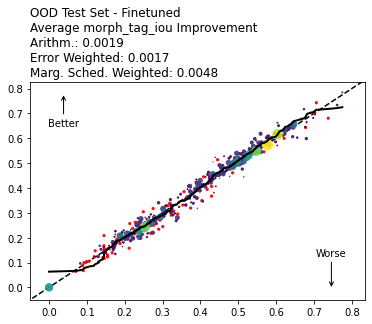

In [48]:
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

metric = "morph_tag_iou"

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

cmap = matplotlib.cm.get_cmap("viridis").copy()
cmap.set_bad('red', 1.0)

baseline_means = []
baseline_errors = []
model_means = []
model_errors = []
colors = []
sizes = []
for morph_tag_set, model_metric_values in baseline_stats.items():
    baseline_values = baseline_stats[morph_tag_set][metric]

    if len(baseline_values) >= 1:
        baseline_means.append(
            np.mean(baseline_values)
        )

        baseline_errors.append(
            np.var(baseline_values)
            #np.std(baseline_values) / np.sqrt(len(baseline_values))
        )

        model_means.append(
            np.mean(model_stats[morph_tag_set][metric])
        )

        model_errors.append(
            marginal_scheduler.get(morph_tag_set, 0.0)
        )

        sizes.append(
            marginal_scheduler_scaled.get(morph_tag_set, 0.05)
        )

        colors.append(
            cmap(marginal_scheduler_scaled.get(morph_tag_set, np.nan))
        )

baseline_means = np.array(baseline_means)
baseline_errors = np.array(baseline_errors)
model_means = np.array(model_means)
model_errors = np.array(model_errors)
colors = np.array(colors)
sizes = np.array(sizes)

figure, ax = plt.subplots(1, 1)

# Plot deltas
max_size = 100

ax.scatter(
    baseline_means[model_errors == 0],
    model_means[model_errors == 0],
    alpha=0.9,
    zorder=1,
    s=max_size*sizes[model_errors == 0],
    c=colors[model_errors == 0],
    )

size_arg_sort = np.argsort(sizes[model_errors != 0])
ax.scatter(
    baseline_means[model_errors != 0][size_arg_sort],
    model_means[model_errors != 0][size_arg_sort],
    alpha=0.9,
    zorder=1,
    s=max_size*sizes[model_errors != 0][size_arg_sort],
    c=colors[model_errors != 0][size_arg_sort],
    )

# Plot 1-1 line
ax.plot([-1, 10], [-1, 10], c="k", ls="--", zorder=0)

# Plot moving average
kernel_size = 50
means_arg_sort = np.argsort(baseline_means)
plt.plot(
    baseline_means[means_arg_sort],
    movingaverage(
        np.pad(
            model_means[means_arg_sort],
            (math.floor(kernel_size/2)-1, math.ceil(kernel_size/2)),
            "edge"
            ),
        kernel_size,
    ),
    c="k",
    ls="-",
    zorder=2,
    linewidth=2,
    )

ax.set_ylim(np.min(baseline_means)-0.05, np.max(baseline_means)+0.05)
ax.set_xlim(np.min(model_means)-0.05, np.max(model_means)+0.05)

x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

ax.annotate(
    'Better',
    xy=(ax.get_xlim()[0] + 0.10 *  x_range, ax.get_ylim()[1] - 0.05 *  y_range),
    xytext=(ax.get_xlim()[0] + 0.10 *  x_range, ax.get_ylim()[1] - 0.20 *  y_range),
    horizontalalignment="center",
    arrowprops=dict(arrowstyle='->',lw=1),
    fontsize=10,
)

ax.annotate(
    'Worse',
    xy=(ax.get_xlim()[1] - 0.10 *  x_range, ax.get_ylim()[0] + 0.05 *  y_range),
    xytext=(ax.get_xlim()[1] - 0.10 *  x_range, ax.get_ylim()[0] + 0.20 *  y_range),
    horizontalalignment="center",
    arrowprops=dict(arrowstyle='->',lw=1),
    fontsize=10,
)

# Compute improvement
w_baseline = 1 / np.clip(baseline_errors, 1e-2, 1e+2)
w_baseline = w_baseline / np.sum(w_baseline)

w_model = model_errors / np.sum(model_errors)

ax.set_title(
    f"OOD Test Set - Finetuned\nAverage {metric} Improvement\nArithm.: {np.mean(model_means - baseline_means):.4f}\nError Weighted: {np.sum(w_baseline * (model_means - baseline_means)):.4f}\nMarg. Sched. Weighted: {np.sum(w_model * (model_means - baseline_means)):.4f}",
    loc="left",
    fontsize=12,
)

plt.show()


In [39]:
np.mean(model_means), np.mean(baseline_means)

(0.5731923350083394, 0.5602764336882741)

In [43]:
np.mean((model_means <= baseline_means)[w_model == 0])

0.5116279069767442

In [27]:
np.exp(np.mean(model_means)), np.exp(np.mean(baseline_means)), np.mean(np.exp(model_means)) - np.mean(np.exp(baseline_means))

(16.02521253155704, 12.48283534960973, 3.886321497910325)

In [33]:
np.exp(np.mean(model_means) - np.mean(baseline_means))

1.2305769476686808

In [37]:
np.mean(model_means[w_model == 0] - baseline_means[w_model == 0])

0.23320621891346108